In [22]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import feature as H
# First lets reed the datasets
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [23]:
merchant_info = spark.read.parquet('../data/curated/full_dataset_Variation/')

In [24]:
linkage = spark.read.csv('../data/curated/sector_lookup_table.csv', header=True)

In [25]:
# pre process industry
merchant_info = merchant_info.select('merchant_abn', 'Description').distinct()

In [26]:
merchant_info = merchant_info.join(linkage, on= merchant_info.Description == linkage.Description, how='inner')

In [27]:
merchant_info = merchant_info.select('merchant_abn', 'sector').distinct()

In [28]:
# Read all our tables 
customer_scaled = spark.read.parquet('../data/Normalised/customer_scaled/')
customer_scaled = customer_scaled.fillna(0.5)
industry_raw = spark.read.parquet('../data/Normalised/industry_scailed/')
industry_raw = industry_raw.fillna(0.5)
merchant_scaled = spark.read.parquet('../data/Normalised/merchant_scaled/')
merchant_scaled = merchant_scaled.fillna(0.5)
revenue_scaled = spark.read.parquet('../data/Normalised/revenue_scailed/')
revenue_scaled = revenue_scaled.fillna(0.5)

In [29]:
# slip ups 
industry_scaled = merchant_info.join(industry_raw, on='sector').drop('sector')
revenue_scaled = revenue_scaled.select('merchant_abn', 'Revenue_Growth_Avg', 'Total_Revenue')

In [30]:
from operator import add
from functools import reduce
# For each table we need to perform the following steps
def scroring_process(dataset, toggle=False):
    # first subtract 1 from each cell then square
    for col in dataset.columns[1:]:
        dataset = dataset.withColumn(col, F.pow((F.col(col) - 1),2))
    # sum the columns 
    if toggle != False:
        dataset.withColumn('Industry_score', F.col('Industry_score') * toggle)
    new_df = dataset.withColumn('total',F.round(reduce(add, [F.col(x) for x in dataset.columns[1:]]), 8))
    return new_df


In [31]:
# Define our scaliong function
def feature_standardisation(dataset): 
    values = dataset.select(F.max('total').alias('high'), F.min('total').alias('low'))
    dataset = dataset.withColumn('total', F.round((F.col('total') - values.select('low').head()[0]) / (values.select('high').head()[0] - values.select('low').head()[0]), 9))
    return dataset.select('merchant_abn', 'total')

In [32]:
# score industry, then add to merchants 
industry_scaled = scroring_process(industry_scaled)
industry_scaled = industry_scaled.select('merchant_abn','total')
industry_scaled = feature_standardisation(industry_scaled)
industry_scaled = industry_scaled.withColumnRenamed('total','Industry_score')
merchant_scaled = merchant_scaled.join(industry_scaled, on='merchant_abn', how='left')

In [33]:
customer_scaled = scroring_process(customer_scaled)
merchant_scaled = scroring_process(merchant_scaled)
revenue_scaled = scroring_process(revenue_scaled)

In [34]:
# rescale them 
customer_scaled = customer_scaled.select('merchant_abn','total')
customer_scaled = feature_standardisation(customer_scaled)
customer_scaled = customer_scaled.withColumnRenamed('total','Customer_score')
revenue_scaled = revenue_scaled.select('merchant_abn','total')
revenue_scaled = feature_standardisation(revenue_scaled)
revenue_scaled = revenue_scaled.withColumnRenamed('total','Revenue_score')
merchant_scaled = merchant_scaled.select('merchant_abn','total')
merchant_scaled = feature_standardisation(merchant_scaled)
merchant_scaled = merchant_scaled.withColumnRenamed('total','Merchant_score')

In [35]:
# Finally join 
Full_scores = customer_scaled.join(revenue_scaled, on='merchant_abn', how='inner').join(merchant_scaled, on='merchant_abn', how='inner')

In [36]:
# now scale and done 
#Industry_scale_factor = 1
Full_scores = scroring_process(Full_scores)

In [37]:
Full_scores = Full_scores.join(merchant_info.join(industry_raw, on='sector').select('merchant_abn', 'sector').distinct(), on='merchant_abn', how='left')

In [38]:
Full_scores.write.parquet('../data/Normalised/Final_scores_alt', mode='overwrite')

In [39]:
Full_scores.orderBy('total')

merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector
51267358936,0.01978842111457032,0.002734449080641...,0.04760055839997249,0.07012343,Personal_Services
76866488151,0.03571687576104992,0.030675506556620036,0.009347573870853911,0.07573996,Personal_Services
15704713883,0.011522631285990405,0.011707148679378087,0.06357232296702564,0.0868021,Arts_Recreation_S...
94110063346,0.007175589268322...,0.050007783720136804,0.055182001492982004,0.11236537,Arts_Recreation_S...
28880110118,0.013614814674121432,0.017838621391935216,0.08943800747101066,0.12089144,Arts_Recreation_S...
88299699256,0.010096594743766975,0.03807481384371458,0.07286396215489502,0.12103537,Personal_Services
80067991455,0.01041290875028291,0.04929437771425038,0.061451868555475866,0.12115916,Arts_Recreation_S...
68548907085,0.01057564910210063,0.05627265137615635,0.05531034781987344,0.12215865,Arts_Recreation_S...
99807059634,0.013676499533085477,0.0347891150307072,0.08185567448395024,0.13032129,Arts_Recreation_S...
38049816588,0.0191568015919776,0.03135851143055571,0.0801403285734116,0.13065564,Personal_Services


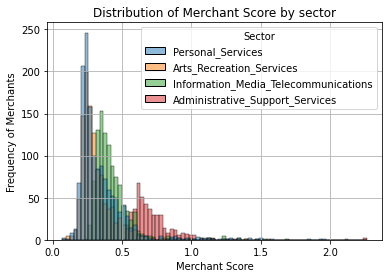

In [50]:
Full_scores = Full_scores.withColumnRenamed('sector', 'Sector')
import seaborn as sns
import matplotlib.pyplot as plt
fig = sns.histplot(x='total', hue='Sector', data=Full_scores.toPandas()).set(title='Distribution of Merchant Score by Sector')
plt.xlabel('Merchant Score')
plt.ylabel('Frequency of Merchants')
plt.title('Distribution of Merchant Score by sector') # You can comment this line out if you don't need title
plt.grid()
plt.show(fig)

In [67]:
pie_data = Full_scores.orderBy('total').limit(100).toPandas()

In [70]:
pie_data.groupby('Sector').count()

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total
Sector,,,,,
Arts_Recreation_Services,44,44,44,44,44
Personal_Services,56,56,56,56,56


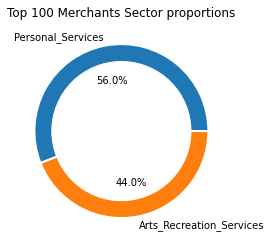

In [77]:
# library
import matplotlib.pyplot as plt
# create data
names = ['Personal_Services', 'Arts_Recreation_Services']
size = [56,44]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.8, color='white')

# Custom wedges
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Top 100 Merchants Sector proportions')
plt.show()